In [1]:
import os
import time
import glob

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

from PIL import Image
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
CATEGORIES = ['01_palm', '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']

In [4]:
images = glob.glob('./leapGestRecog/**/**/**/*.png')

label = [int(os.path.basename(i).split('_')[2])-1 for i in images]

In [5]:
train_transformer = transforms.Compose([
                    transforms.Resize((48, 128)),  # пропорциональное изменение от первоначального размера 240х640
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()])

test_transformer = transforms.Compose([
                   transforms.Resize((48, 128)),
                   transforms.Grayscale(num_output_channels=1),
                   transforms.ToTensor()])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, label, test_size = 0.3, random_state=42)

In [7]:
class LeapGestRecogDataset(Dataset):
    def __init__(self, filenames, labels, transform):      
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

In [8]:
train_dataset = LeapGestRecogDataset(X_train, y_train, train_transformer)
test_dataset = LeapGestRecogDataset(X_test, y_test, test_transformer)

In [9]:
batch_size = 32
lr = 0.01
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size)

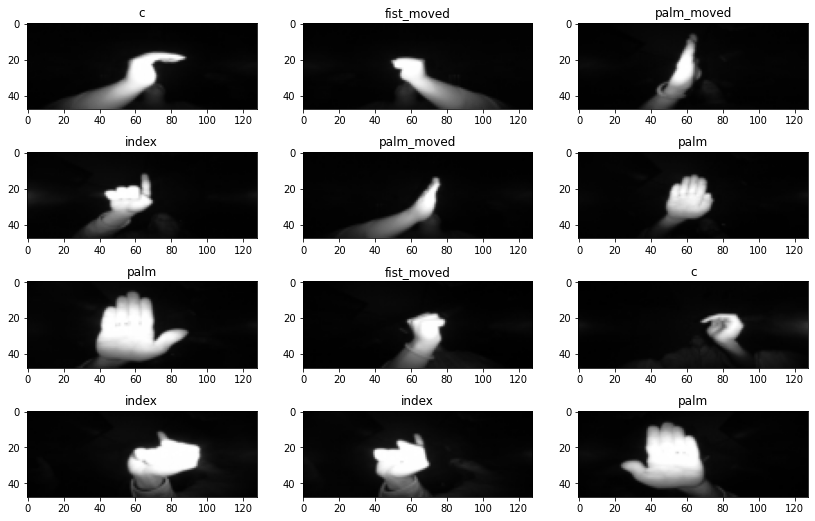

In [10]:
data_iter = iter(train_dl)

img, labels = data_iter.next()

plt.figure(figsize=(14, 21))
for i in range(batch_size):
    ax = plt.subplot(9, 3, i+1)
    plt.imshow(img[i, 0, :, :], cmap='gray')
    plt.title(f'{CATEGORIES[int(labels[i])][3:]}')
    if i > 10:
        break

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(32*22*62, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [12]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [13]:
epochs = 10

In [14]:
def fit(model, epochs):
    
    epoch_losses = []
    epoch_acc = []
    epoch_val_losses = []
    epoch_val_acc = []
    bundle = 20

    for epoch in range(epochs):
        running_loss = 0.0
        cum_loss = []
        cum_acc = []

        time1 = time.time()
        model.train()
        for i, data in enumerate(train_dl, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            cum_loss.append(loss.item())

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            cum_acc.append(correct / total)

        time2 = time.time()
        epoch_losses.append(np.mean(cum_loss))
        epoch_acc.append(np.mean(cum_acc))

        cum_loss = []
        cum_acc = []
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for i, data in enumerate(test_dl, 0):
                inputs, labels = data
                inputs = inputs.to(device) 
                labels = labels.to(device) 

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                cum_loss.append(loss.item())

                total = labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct = (predicted == labels).sum().item()
                cum_acc.append(correct / total)

        epoch_val_losses.append(np.mean(cum_loss))
        epoch_val_acc.append(np.mean(cum_acc))
        print(f'Epochs: {epoch+1}   loss: {epoch_losses[-1]:.5f}   '
              f'accuracy: {epoch_acc[-1]*100:.3f}%   '
              f'loss_val: {epoch_val_losses[-1]:.5f}   '
              f'accuracy_val: {epoch_val_acc[-1]*100:.3f}%   '
              f'time = {time2-time1:.2f} s')
        
    return {'epoch_losses': epoch_losses, 
            'epoch_val_losses': epoch_val_losses, 
            'epoch_acc': epoch_acc, 
            'epoch_val_acc': epoch_val_acc}

In [15]:
history = fit(model, epochs)

Epochs: 1   loss: 1.70866   accuracy: 41.531%   loss_val: 1.33902   accuracy_val: 54.039%   time = 77.23 s
Epochs: 2   loss: 0.76567   accuracy: 75.428%   loss_val: 0.41159   accuracy_val: 86.203%   time = 79.36 s
Epochs: 3   loss: 0.32897   accuracy: 89.840%   loss_val: 0.15363   accuracy_val: 95.495%   time = 77.51 s
Epochs: 4   loss: 0.17559   accuracy: 94.920%   loss_val: 0.06917   accuracy_val: 98.188%   time = 78.64 s
Epochs: 5   loss: 0.13937   accuracy: 96.019%   loss_val: 0.09061   accuracy_val: 97.257%   time = 79.85 s
Epochs: 6   loss: 0.08957   accuracy: 97.524%   loss_val: 0.49234   accuracy_val: 87.932%   time = 76.47 s
Epochs: 7   loss: 0.08717   accuracy: 97.631%   loss_val: 0.03176   accuracy_val: 99.235%   time = 75.52 s
Epochs: 8   loss: 0.05070   accuracy: 98.687%   loss_val: 0.05028   accuracy_val: 98.554%   time = 75.40 s
Epochs: 9   loss: 0.03824   accuracy: 99.023%   loss_val: 0.01621   accuracy_val: 99.535%   time = 75.20 s
Epochs: 10   loss: 0.03012   accuracy

In [16]:
torch.save(model.state_dict(), './leapGestRecog/gesture_recognition')

In [17]:
net = Net().to(device)
net.load_state_dict(torch.load('./leapGestRecog/gesture_recognition', map_location=torch.device('cpu')))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=43648, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Correct: 32 / 32


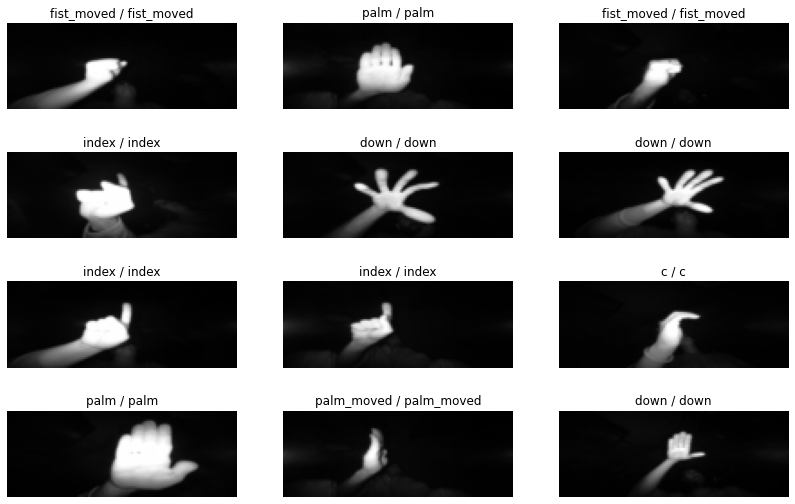

In [18]:
data_iter = iter(test_dl)

img, labels = data_iter.next()

model.eval()
with torch.no_grad():
    inputs = img.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    print(f'Correct: {correct} / {batch_size}')

plt.figure(figsize=(14, 21))
for i in range(batch_size):
    ax = plt.subplot(9, 3, i+1)
    
    plt.imshow(img[i, 0, :, :], cmap='gray')
    if int(labels[i]) == int(predicted[i]):
        plt.title(f'{CATEGORIES[int(labels[i])][3:]} / {CATEGORIES[int(predicted[i])][3:]}')
    else:
        plt.title(f'Error: {CATEGORIES[int(labels[i])][3:]} / {CATEGORIES[int(predicted[i])][3:]}')
    plt.axis('off')
    if i > 10:
        break